In [47]:
from IPython.core.display import HTML
HTML('<style>.container { width:95% !important; }</style>') 

In [6]:
import random
import numpy as np
random.seed(10)
np.random.seed(100)

# >X57128.1_136-761-context-only
# cuaacuuucgcaagcgagucucgcgacaauugcagaagccuagugaguugcggucguguuuguugcuuaaaccagcaguccgucuacaacuccucggcuacaucauaacuugccuuugugcucuccccugcgagcgccgcucuccgccgcuugcacggcgccgcugcuuaaucgucgaaaauccugcaacagcugccaacaaugacucaagucuuauaggccacugccuggugcuucccguuucuugaaagauaugaaggcacccgggagaagccgggaagcaagcgucagugguggccgcugccuccacggcaaugcgucaucacucucacugcugccaggcagggcugcgacaaugccuggcgaaauacaucagcgcgcgguaagcgaaagcggcucaucgaaguacuccgcgacggggggacaacaguggccgagaaugccacuccacucccgucaccccagaagcgcccucggucaguuccuguccauuuagcaaagacaacaagacagaaacaauuuguuuccacuacacuuauuuccuccuaaacgguaggcucauuaaguuaaauugguaguuacaucauguguuaacgugac
# trna = "ggcggcauggccaagcgguaaggcaggggacugcaaauccuuuauccccaguucaaaucugggugccgccu";
# trna2 >X70810.2_30807-30878

trna="GCCUUUUUAGCUCAGUGGUAGAGCAUUGUAUUUGUAAUGCGGUGGUCGUCGGUUCGAAUCCGACAAAAGGCU"
context_trna = "uaugauauuuuuauaguguuuuauucauggaucaauucuauuuuuuauuagcacgugguuuuauuuuguuaaauuguaaa\
uccguauuauuuauaaauugauccuagcucaaaguucaguauuuuuaaauuuuuuuaguuuuaaauaaauauuuuguauaaaaaugugugauuauuu\
aaaagauuucuuccauuucaugacuuuuaauuuuaaaaaaaaauuucaaguauguggccauguauccguauuuggagacaagaagcaagaaaagguu\
uucuuuauaaaaaaguuuagguguuu\
uuauuuuagguaacuuuuuaagcguguuucaccggugcauucaguuuuuuuaguaaugcauaugucauugcaauuuuagcauuauguaaucuuaaa\
agcuuuugucauauuucucaacugcuaugauauauugauaggaguccuucucaauggaugcgggagaauaaauauauuguucacgguagucuaaggc\
ucauugcccccuuuuuaaagucuuagcuuucaucaugcccaggauaaaauaaucaguguugcaauaguucaaauaagcuuaauucaaaguuuauuuuagaggaucgg"


In [7]:
%load_ext autoreload
%autoreload 2
from local_dotplot_lib import *


import RNA
from altschulEriksonDinuclShuffle import dinuclShuffle

import pandas as pd
from matplotlib import pyplot as plt
# import mpld3 
# from mpld3 import plugins
# mpld3.enable_notebook()

def plot_scatter(x, y, xlab, ylab, labels, fig, ax, color=None, scale='linear'):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    y = [yy + 1e-5 for yy in y ]
    if color is not None:
        cc = color
    else:
        cc = 'skyblue'
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    ax.set_yscale(scale)
    #ax.set_xlim([1,])
    if scale =='log':
       ax.set_yscale(scale)
       ax.set_ylim([1e-6, 20])
    if scale =='linear':
       ax.set_yscale(scale)
       ax.set_ylim([-0.05,1.3])
    
    points = ax.scatter(x, y, s=10, linewidth='0', c=cc)

    # Connect d3 points with mouse over lables
    # tooltip = plugins.PointLabelTooltip(points, labels)
    # plugins.connect(fig, tooltip)

def plot_scatter_df(mydf, pdfname='defaultname', scale='linear', what='both', plot_mfe=False, plot_quake=False):
    
    if what == 'both':
        fig = plt.figure(figsize=(10, 10))
        subplot_num = 210
    else:
        fig = plt.figure(figsize=(10, 5))
        subplot_num = 110
    
#     mpld3.plugins.clear(fig)  # clear all plugins from the figure    
    suffix = ""
    if plot_mfe:
        suffix += "-mfe"
    else:
        suffix += "-prob"
    
    if plot_quake:
        suffix += "-quake"
    import matplotlib.patches as mpatches

    # if scale == 'linear':
    #    ax.set_ylim([min(-20,  min(mydf[nameY])),max(30, max(mydf[nameY]))])
    # import math
    #     yrange = round(mydf[nameY].median()/10) * 10
    #     print "{} median: {}".format(nameY, mydf[nameY].median())
    #     ax.set_ylim([yrange-100, yrange+100])#[mydf[nameY].median() - 10 ,mydf[nameY].median() + 10])
    color_pallete = ['b', "#e41a1c","#386cb0","#1b9e77","#984ea3", "#ff7f00","#ffff33","#a65628","#f781bf"]
    if plot_quake:
        pdfname += "-Quake"
    else:
        pdfname += "-Turner"
    
    if plot_quake:
        extend_color = color_pallete[0]    
    else:
        extend_color = color_pallete[0]
    if what == 'both' or what=='split':
        subplot_num+=1
        ax = fig.add_subplot(subplot_num)
        plot_scatter(mydf['context-length'], mydf['split'+suffix], 'context-length', (suffix.split("-"))[1], 
                 [str(v) for v in list(mydf.index.values)], fig, ax, 
                 color='y', scale=scale)
        patch = mpatches.Patch(label='Extend-' + pdfname)
        ax.legend(handles=[patch], loc='best', shadow=False)

    if what == 'both' or what=='extend':
        subplot_num+=1
        ax = fig.add_subplot(subplot_num)
        plot_scatter(mydf['context-length'], mydf['extend'+suffix], 'context-length', (suffix.split("-"))[1],
                     [str(v) for v in list(mydf.index.values)], fig, ax, 
                     color=extend_color, scale=scale)
        patch = mpatches.Patch(label='Extend-' + pdfname)
        ax.legend(handles=[patch], loc='best', shadow=False)


#     fig.suptitle(pdfname+"-"+what, y =0.96)
    fig.savefig (pdfname+"-"+what+".svg", dpi=600) #, bbox_inches='tight')
    print "Plot saved to: ", pdfname+"-"+what+".svg"

def my_eval(rna_seq, context, l_pos, r_pos, rna_split_pos, step=10, quake_opts=[False], use_pywrapper=False, max_context_size=300, repeats=1):
    context = context.upper()
    cont_lengths, inner_probs, outer_probs, inner_mfes, outer_mfes = [] , [], [], [], []
    inner_probs_quake, outer_probs_quake, inner_mfes_quake, outer_mfes_quake = [] , [], [], []
    assert (not  use_pywrapper) # Availability of RNAlib wrapper with non-Turner parameter not checked
    for context_len in range(0,max_context_size,step):
        for irepeat in range(repeats):
            # select a range of the context, each time reshuffle to not stick into a (rare) sub-minimal case
            selection = dinuclShuffle(context)[0:context_len]
            # Insert the rna inbetween selection, insert position is from a normal distribution with mean 
            # be the center of the selected context
            center_pos = len(selection)/2
            insert_pos = max(0, int(np.random.normal(center_pos, 1+center_pos*0.1 )))
            print '.',
            # print "(", context_len, center_pos, insert_pos, ")", 
            full_seq_inner = selection[:insert_pos] +  rna_seq + selection[insert_pos:]
            full_seq_outer = rna_seq[:rna_split_pos] +  selection + rna_seq[rna_split_pos:]
            if use_pywrapper:
                structure = ""
                RNA.pf_fold(full_seq_inner, structure)
                inner_prob = RNA.get_pr(insert_pos+l_pos+1,insert_pos+r_pos+1)

                RNA.free_pf_arrays()

                RNA.pf_fold(full_seq_outer, structure)
                outer_prob = RNA.get_pr(l_pos+1,len(selection)+r_pos+1)
                RNA.free_pf_arrays()
                # print len([p for p in outer_probs if p< 0.5])
                # print len([p for p in inner_probs if p< 0.5])
            else:  # Use binary call
                for quake in quake_opts:
                    import tempfile
                    tmp_path = tempfile.mkdtemp(dir="./")
                    tmp_path += "/"
                    out_fasta_file = tmp_path + "/tmp.fa"
                    with open(out_fasta_file, "w") as out_fasta_handle:
                #         SeqIO.write([], out_fasta_file, "fasta")
                        out_fasta_handle.write(">{}\n{}\n".format("seq_inner", full_seq_inner))
                        out_fasta_handle.write(">{}\n{}\n".format("seq_outer", full_seq_outer))
                    dangles=2
                    which_param = 'turner'
                    if quake:
                        which_param = 'quake'
                    dp_out_path = compute_part_func(out_fasta_file, ["seq_inner", "seq_outer"], tmp_path, 
                                                    which_params=which_param, 
                                                    dangles=dangles)
                    dp_matrix_inner = parse_dp_ps(dp_out_path+"/seq_inner_dp.ps") 
                    dp_matrix_outer = parse_dp_ps(dp_out_path+"/seq_outer_dp.ps")
                    if quake:
                        inner_prob_quake = dp_matrix_inner[insert_pos+l_pos, insert_pos+r_pos]
                        inner_mfe_quake = dp_matrix_inner[insert_pos+r_pos, insert_pos+l_pos]
                        outer_prob_quake = dp_matrix_outer[l_pos,len(selection)+r_pos]
                        outer_mfe_quake = dp_matrix_outer[len(selection)+r_pos, l_pos]
                    else:
                        inner_prob = dp_matrix_inner[insert_pos+l_pos, insert_pos+r_pos]
                        inner_mfe = dp_matrix_inner[insert_pos+r_pos, insert_pos+l_pos]
                        outer_prob = dp_matrix_outer[l_pos,len(selection)+r_pos]
                        outer_mfe = dp_matrix_outer[len(selection)+r_pos, l_pos]

            cont_lengths.append(context_len)
            inner_probs_quake.append(inner_prob_quake)
            outer_probs_quake.append(outer_prob_quake)
            inner_mfes_quake.append(inner_mfe_quake)
            outer_mfes_quake.append(outer_mfe_quake)
            inner_probs.append(inner_prob)
            outer_probs.append(outer_prob)
            inner_mfes.append(inner_mfe)
            outer_mfes.append(outer_mfe)
    
    print ""
    df = pd.DataFrame()
    df['context-length'], df['extend-prob'], df['split-prob'], df['extend-mfe'], df['split-mfe'] ,\
        df['extend-prob-quake'], df['split-prob-quake'], df['extend-mfe-quake'], df['split-mfe-quake'] = [pd.Series(entry) for entry in 
                                                   [cont_lengths, inner_probs, outer_probs, inner_mfes, outer_mfes,
                                                   inner_probs_quake, outer_probs_quake, inner_mfes_quake, outer_mfes_quake]]
    df.set_index('context-length')
    
    return df


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
df_trna_both = my_eval(trna, context_trna, 3, 67, 34, step=1, repeats=5, max_context_size=200,use_pywrapper=False, quake_opts=[False, True],) 

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

In [9]:
df_trna_both.head()

,context-length,extend-prob,split-prob,extend-mfe,split-mfe,extend-prob-quake,split-prob-quake,extend-mfe-quake,split-mfe-quake
0,0,0.994732,0.994732,1.0,1.0,0.997637,0.997637,1.0,1.0
1,10,0.994067,0.994733,1.0,1.0,0.997576,0.997637,1.0,1.0
2,20,0.945340,0.994724,1.0,1.0,0.994253,0.997636,1.0,1.0
3,30,0.747326,0.994592,1.0,1.0,0.985214,0.997620,1.0,1.0
4,40,0.814627,0.994707,1.0,1.0,0.994568,0.997634,1.0,1.0


In [11]:
df_trna_both.head()

,context-length,extend-prob,split-prob,extend-mfe,split-mfe,extend-prob-quake,split-prob-quake,extend-mfe-quake,split-mfe-quake
0,0,0.994732,0.994732,1.0,1.0,0.997637,0.997637,1.0,1.0
1,10,0.994067,0.994733,1.0,1.0,0.997576,0.997637,1.0,1.0
2,20,0.945340,0.994724,1.0,1.0,0.994253,0.997636,1.0,1.0
3,30,0.747326,0.994592,1.0,1.0,0.985214,0.997620,1.0,1.0
4,40,0.814627,0.994707,1.0,1.0,0.994568,0.997634,1.0,1.0


['[0, 20]', '(20, 50]', '(50, 100]', '(100, 200]']
Plot saved to:  boxplot-tRNA-Turner-extend.svg
['[0, 20]', '(20, 50]', '(50, 100]', '(100, 200]']
Plot saved to:  boxplot-tRNA-Quake-extend.svg


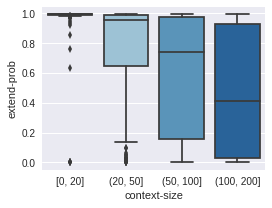

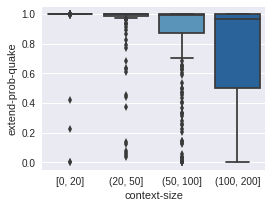

In [108]:
%matplotlib inline
import seaborn as sns
def plot_box_df(mydf, pdfname='defaultname', scale='linear', what='both', plot_mfe=False, plot_quake=False, ranges=[0,25,50,200]):
    
    if what == 'both':
        fig = plt.figure(figsize=(10, 10))
        subplot_num = 210
    else:
        fig = plt.figure(figsize=(4, 3))
        subplot_num = 110 #(len(ranges)-1)*100 + 10
    
    suffix = ""
    if plot_mfe:
        suffix += "-mfe"
    else:
        suffix += "-prob"
    
    if plot_quake:
        suffix += "-quake"

    # if scale == 'linear':
    #    ax.set_ylim([min(-20,  min(mydf[nameY])),max(30, max(mydf[nameY]))])
    # import math
    #     yrange = round(mydf[nameY].median()/10) * 10
    #     print "{} median: {}".format(nameY, mydf[nameY].median())
    #     ax.set_ylim([yrange-100, yrange+100])#[mydf[nameY].median() - 10 ,mydf[nameY].median() + 10])
    color_pallete = ['b', "#e41a1c","#386cb0","#1b9e77","#984ea3", "#ff7f00","#ffff33","#a65628","#f781bf"]
    if plot_quake:
        pdfname += "-Quake"
    else:
        pdfname += "-Turner"
    
    if plot_quake:
        extend_color = color_pallete[0]    
    else:
        extend_color = color_pallete[0]
    if what == 'both' or what=='split':
        subplot_num+=1
        ax = fig.add_subplot(subplot_num)
        sns.boxplot(mydf['context-length'], mydf['split'+suffix],ax=ax)
#         plot_scatter(mydf['context-length'], mydf['split'+suffix], 'context-length', (suffix.split("-"))[1], 
#                  [str(v) for v in list(mydf.index.values)], fig, ax, 
#                  color='y', scale=scale)
#         patch = mpatches.Patch(label='Extend-' + pdfname)
        ax.legend(handles=[patch], loc='best', shadow=False)

    if what == 'both' or what=='extend':
        subplot_num+=1
        ax = fig.add_subplot()#subplot_num)
        #vals = mydf['extend'+suffix][(ranges[ir]<mydf['context-length']) & (mydf['context-length'] <=ranges[ir+1])]
        mydf['context-size']= pd.cut(mydf['context-length'], ranges, include_lowest=True).astype(str)
        order = sorted(set(mydf['context-size'])-set(['nan']), reverse=False, key=lambda t: (int(re.findall('\d+', t)[0])))
        print order
        sns.boxplot( data=mydf, ax=ax, x= 'context-size', y='extend'+suffix,  order=order, orient='v', palette='Blues')
#         ax.set_xlim([0,1])

#         plot_scatter(mydf['context-length'], mydf['extend'+suffix], 'context-length', (suffix.split("-"))[1],
#                      [str(v) for v in list(mydf.index.values)], fig, ax, 
#                      color=extend_color, scale=scale)
        #patch = mpatches.Patch(label='Extend-' + pdfname)
        #ax.legend(handles=[patch], loc='best', shadow=False)


#     fig.suptitle(pdfname+"-"+what, y =0.96)
    pdfname = 'boxplot-' + pdfname
    fig.savefig (pdfname+"-"+what+".svg", dpi=300, bbox_inches='tight')
    print "Plot saved to: ", pdfname+"-"+what+".svg"
# plot_box_df(df_trna_both, 'tRNA',what='extend', plot_quake=True)
plot_box_df(df_trna_both, 'tRNA',what='extend', ranges=[0,20,50,100, 200])
plot_box_df(df_trna_both, 'tRNA',what='extend', plot_quake=True, ranges=[0,20,50,100,200])


In [77]:
pd.cut(df_trna_both['context-length'], [0,1], include_lowest=True)

0      [0, 1]
1      [0, 1]
2      [0, 1]
3      [0, 1]
4      [0, 1]
5      [0, 1]
6      [0, 1]
7      [0, 1]
8      [0, 1]
9      [0, 1]
10        NaN
11        NaN
12        NaN
13        NaN
14        NaN
15        NaN
16        NaN
17        NaN
18        NaN
19        NaN
20        NaN
21        NaN
22        NaN
23        NaN
24        NaN
25        NaN
26        NaN
27        NaN
28        NaN
29        NaN
        ...  
970       NaN
971       NaN
972       NaN
973       NaN
974       NaN
975       NaN
976       NaN
977       NaN
978       NaN
979       NaN
980       NaN
981       NaN
982       NaN
983       NaN
984       NaN
985       NaN
986       NaN
987       NaN
988       NaN
989       NaN
990       NaN
991       NaN
992       NaN
993       NaN
994       NaN
995       NaN
996       NaN
997       NaN
998       NaN
999       NaN
Name: context-length, dtype: category
Categories (1, object): [[0, 1]]

In [59]:
df_trna_both.notnull()

,context-length,extend-prob,split-prob,extend-mfe,split-mfe,extend-prob-quake,split-prob-quake,extend-mfe-quake,split-mfe-quake,context-size
0,True,True,True,True,True,True,True,True,True,True
1,True,True,True,True,True,True,True,True,True,True
2,True,True,True,True,True,True,True,True,True,True
3,True,True,True,True,True,True,True,True,True,True
4,True,True,True,True,True,True,True,True,True,True
5,True,True,True,True,True,True,True,True,True,True
6,True,True,True,True,True,True,True,True,True,True
7,True,True,True,True,True,True,True,True,True,True
8,True,True,True,True,True,True,True,True,True,True
9,True,True,True,True,True,True,True,True,True,True


TypeError: unsupported operand type(s) for /: 'str' and 'int'

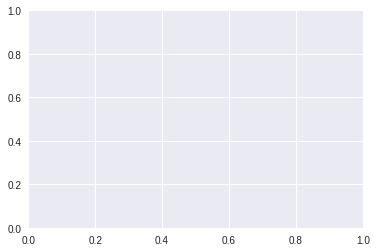

In [208]:
df_trna_both['X'] = [str(c) for c in pd.cut(df_trna_both['context-length'], [0,2,4,300], include_lowest=True)]
sns.boxplot(data=df_trna_both, x='extend-prob', y='X', orient='v')

In [204]:
df_trna_both.head()

,context-length,extend-prob,split-prob,extend-mfe,split-mfe,extend-prob-quake,split-prob-quake,extend-mfe-quake,split-mfe-quake,ranges,context size,context-size,X
0,0,0.000000,0.994732,0.0,1.0,0.000000,0.997637,0.0,1.0,"[0, 20]","[0, 20]","[0, 20]","[0, 2]"
1,0,0.994732,0.994732,1.0,1.0,0.997637,0.997637,1.0,1.0,"[0, 20]","[0, 20]","[0, 20]","[0, 2]"
2,0,0.994732,0.994732,1.0,1.0,0.997637,0.997637,1.0,1.0,"[0, 20]","[0, 20]","[0, 20]","[0, 2]"
3,0,0.994732,0.994732,1.0,1.0,0.997637,0.997637,1.0,1.0,"[0, 20]","[0, 20]","[0, 20]","[0, 2]"
4,0,0.994732,0.994732,1.0,1.0,0.997637,0.997637,1.0,1.0,"[0, 20]","[0, 20]","[0, 20]","[0, 2]"


In [205]:
df_trna_both.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
context-length       1000 non-null int64
extend-prob          1000 non-null float64
split-prob           1000 non-null float64
extend-mfe           1000 non-null float64
split-mfe            1000 non-null float64
extend-prob-quake    1000 non-null float64
split-prob-quake     1000 non-null float64
extend-mfe-quake     1000 non-null float64
split-mfe-quake      1000 non-null float64
ranges               1000 non-null category
context size         1000 non-null category
context-size         1000 non-null object
X                    1000 non-null object
dtypes: category(2), float64(8), int64(1), object(2)
memory usage: 88.0+ KB


Plot saved to:  tRNA-Quake-extend.svg
Plot saved to:  tRNA-Turner-extend.svg


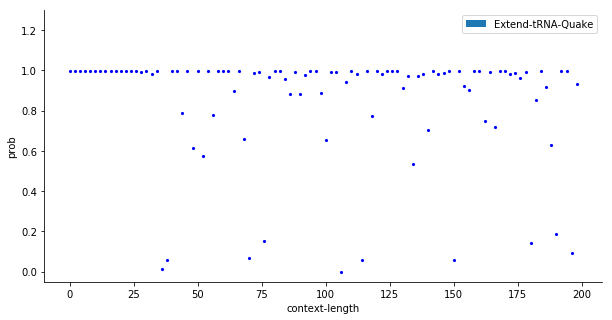

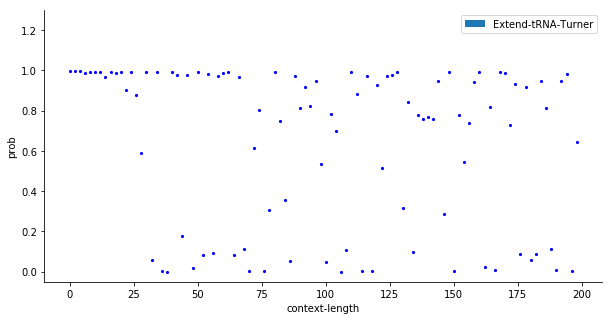

In [29]:
%matplotlib inline
# stem="CAUUGUAUUUGUAAUGCGGUG"
# stem2="GCCUUUUAAAAGGC"
# df_stem = my_eval(stem, context_trna2, 3, 17, 7, 10)
# df_stemtest = my_eval(stem2, context_trna2, 3, 10, 8, 50)

# plot_scatter_df(df_stemtest, 'stem',what='both')
# plot_scatter_df(df_stem, 'stem-Log-', scale='log', what='split')
# plot_scatter_df(df_stem, 'stem',what='extend')
# plot_scatter_df(df_stem, 'stem-Log-', scale='log', what='extend')

# plot_scatter_df(df_trna_both, 'tRNA',what='extend', plot_mfe=True, plot_quake=True)
# plot_scatter_df(df_trna_both, 'tRNA',what='extend', plot_mfe=True, plot_quake=False)


# plot_scatter_df(df_trna_arc_b, 'tRNA arc-b')
# plot_scatter_df(df_trna_arc_b, 'tRNA arc-b Log(p(i,j))', scale='log')
plot_scatter_df(df_trna_both, 'tRNA',what='extend', plot_quake=True)
plot_scatter_df(df_trna_both, 'tRNA',what='extend')

# plot_scatter_df(df_trna_both, 'tRNA-Log', scale='log', what='extend', plot_quake=True)
# plot_scatter_df(df_trna_both, 'tRNA-Log', scale='log', what='extend')

# plot_scatter_df(df_trna, 'tRNA',what='extend')
# plot_scatter_df(df_trna, 'tRNA-Log-', scale='log', what='extend')


# my_plot(trna_lengths, trna_inners, trna_outers )

Plot saved to:  tRNA-Quake-both.svg
Plot saved to:  tRNA-Turner-both.svg
Plot saved to:  tRNA-quake-Quake-both.svg
Plot saved to:  tRNA-Turner-both.svg


/home/milad/miniconda2/envs/mmfold/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'DejaVu Sans Display'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Plot saved to:  tRNA-Log-quake-Quake-extend.svg
Plot saved to:  tRNA-Log--Turner-extend.svg


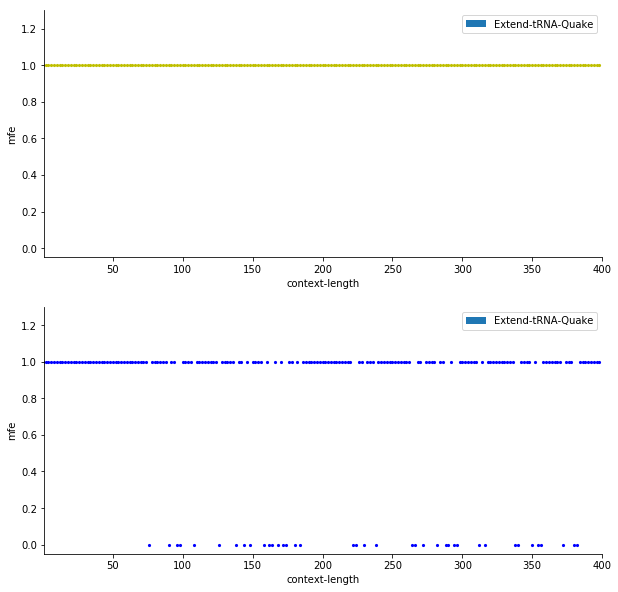

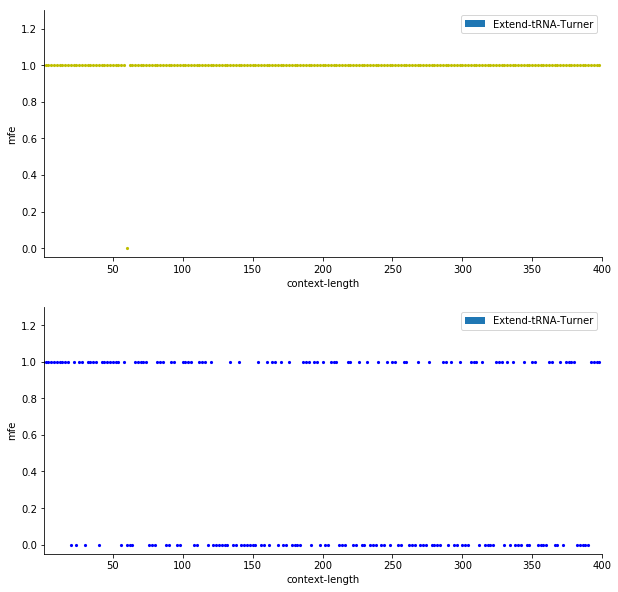

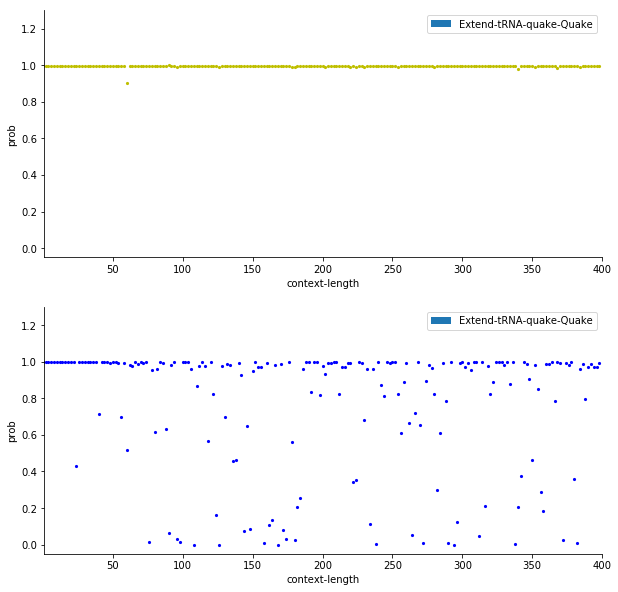

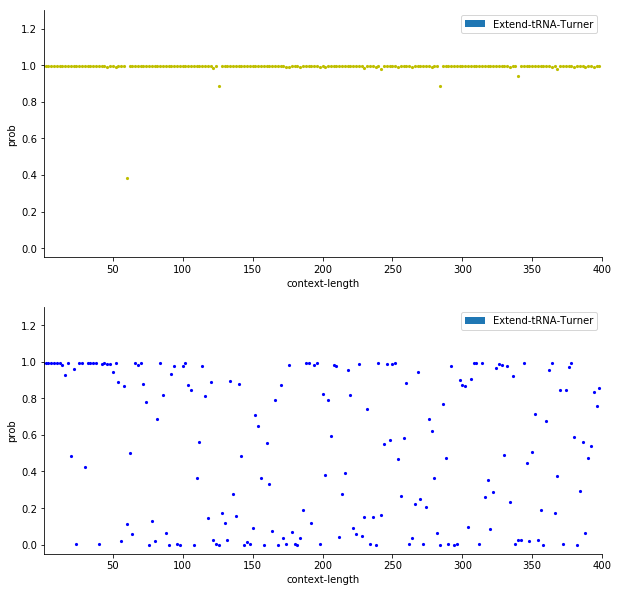

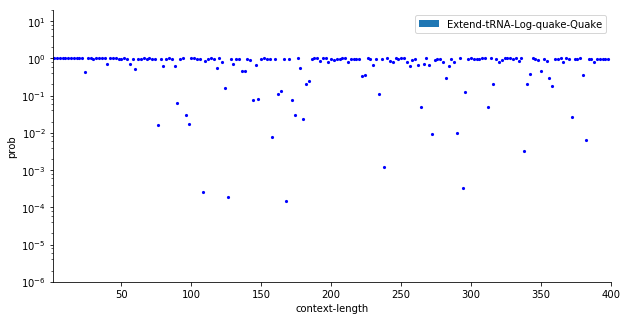

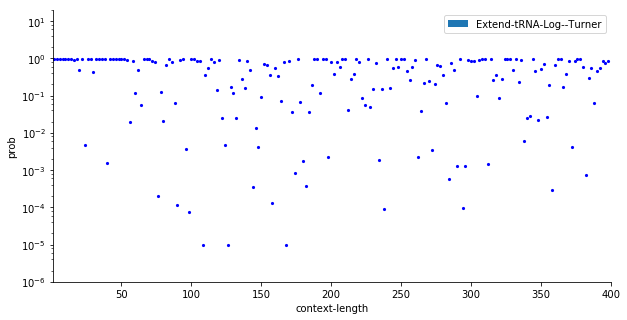

In [7]:
# df_trnaa = my_eval(trna2, context_trna2, 2, 68, 34, 2)
# df_trna_quake = my_eval(trna2, context_trna2, 3, 67, 34, 5, use_pywrapper=False, use_quake=True) 
# df_trna = my_eval(trna2, context_trna2, 3, 67, 34, 5, use_pywrapper=False, use_quake=False) 
# df_trna_both = my_eval(trna2, context_trna2, 3, 67, 34, 2, use_pywrapper=False, quake_opts=[False, True]) 

# stem="CAUUGUAUUUGUAAUGCGGUG"
# stem2="GCCUUUUAAAAGGC"
# df_stem = my_eval(stem, context_trna2, 3, 17, 7, 10)
# df_stemtest = my_eval(stem2, context_trna2, 3, 10, 8, 50)
# plot_scatter_df(df_stemtest, 'stem',what='both')
# plot_scatter_df(df_stem, 'stem-Log-', scale='log', what='split')
# plot_scatter_df(df_stem, 'stem',what='extend')
# plot_scatter_df(df_stem, 'stem-Log-', scale='log', what='extend')
plot_scatter_df(df_trna_both, 'tRNA',what='both', plot_mfe=True, plot_quake=True)
plot_scatter_df(df_trna_both, 'tRNA',what='both', plot_mfe=True, plot_quake=False)


# plot_scatter_df(df_trna_arc_b, 'tRNA arc-b')
# plot_scatter_df(df_trna_arc_b, 'tRNA arc-b Log(p(i,j))', scale='log')
plot_scatter_df(df_trna_both, 'tRNA-quake',what='both', plot_quake=True)
plot_scatter_df(df_trna_both, 'tRNA',what='both')

plot_scatter_df(df_trna_both, 'tRNA-Log-quake', scale='log', what='extend', plot_quake=True)
plot_scatter_df(df_trna_both, 'tRNA-Log-', scale='log', what='extend')

# plot_scatter_df(df_trna, 'tRNA',what='extend')
# plot_scatter_df(df_trna, 'tRNA-Log-', scale='log', what='extend')


# my_plot(trna_lengths, trna_inners, trna_outers )

In [14]:
# df_trna_both_lovely = df_trna_both.copy()
df_trna_both_lovely


NameError: name 'df_trna_both_lovely' is not defined

[1, 3]


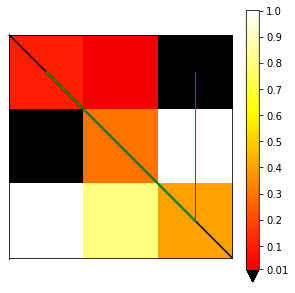

In [8]:
%matplotlib inline
# mpld3.enable_notebook()

mynp = np.array([[0.1,0.01,0.001],[0.00,0.3,1.0],[1.0,0.8,.4]])
fig = plt.figure(figsize = (5,5)) 
ax = fig.add_subplot(111)
# my_heatmap(mynp, fig, ax)
my_heatmap(mynp, fig, ax, inverse=False, interactive=False, gene_loc=[1,3])


In [17]:
# RNA.get_pr(l_pos+1, r_pos+1)
# context_histone_shuffled = dinuclShuffle(context_histone.upper())
# context_trna2_shuffled = dinuclShuffle(context_trna2.upper())

# my_heatmaps(histone, context_histone_shuffled,context_len = 150, filename='histone-shuffled-150', 
#            what='all')
my_heatmaps(trna2, context_trna2_shuffled, insert_pos=100, context_len=150, filename='trna-shuffled-150',
           what ='all')
# my_heatmaps(trna2, context_trna2_shuffled, context_len=0, filename='trna-shuffled-0')



NameError: name 'context_trna2_shuffled' is not defined

[139, 210]
[139, 210]


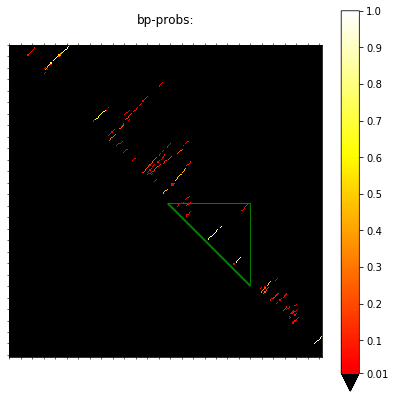

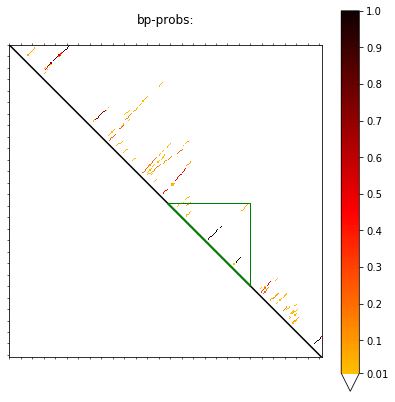

In [9]:
plot_dp_ps('../sample_trna2_nonsymmetric_mm_dp.filt.ps', gene_loc=[139, 210])
plot_dp_ps('../sample_trna2_nonsymmetric_mm_dp.filt.ps', gene_loc=[139, 210], inverse=True)

[139, 210]
[139, 210]


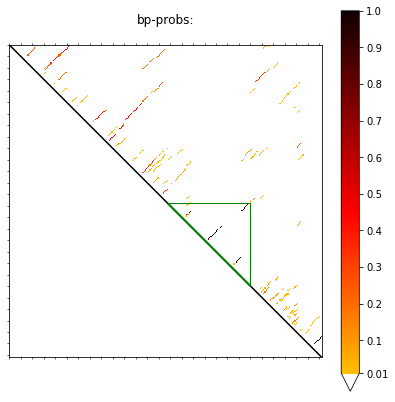

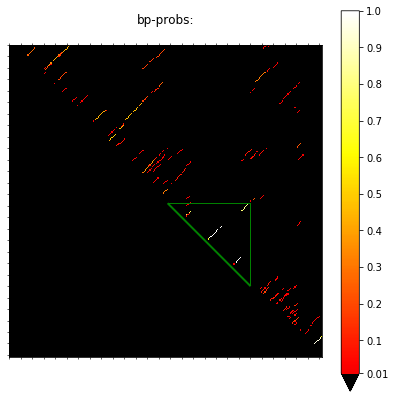

In [11]:
plot_dp_ps('../sample_trna2_nonsymmetric_dp_quake.ps', gene_loc=[139, 210], inverse=True)
plot_dp_ps('../sample_trna2_nonsymmetric_dp_quake.ps', gene_loc=[139, 210], inverse=False)

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
[139, 210]
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
[139, 210]


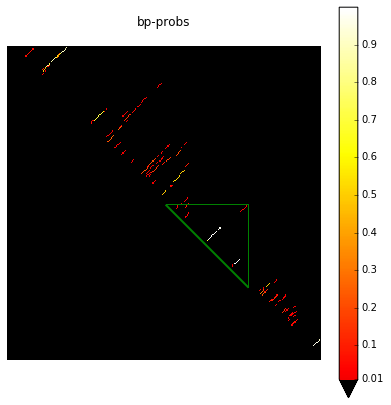

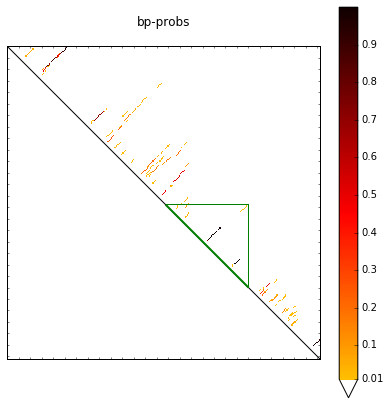

In [175]:
plot_dp_ps('../sample_trna2_nonsymmetric_mm_dp.filt.ps', gene_loc=[139, 210])
plot_dp_ps('../sample_trna2_nonsymmetric_mm_dp.filt.ps', gene_loc=[139, 210], inverse=True)

In [ ]:
# >BX571868.1_244896-246219 CONTEXT 500 Rfam RF00040:245396-245719;	sequence=known_nt;	324;	rne5;	RNase E 5' UTR element;	EMBL desc: Photorhabdus luminescens subsp. laumondii TTO1 complete genome; segment 10/17
context_rne5 = "UAUAAGAUACAAUCGUCUAAUGCAGCGACUUUAUCCAGUUUAGCUGAAACUGGCACUGCUUGCCGUUCUGCAACCCGAACCGGUGG\
AAUUCUGACAACAUCCCCCGCAGACAAUUUAUACUCAGGUUUUAUCCUGCCUUUAUUUAUCCGCACUUCCCCCUUACGCACAAUCCGGUAAAUC\
AUGCUCUUAGGAACACCCUUCAAACGCGCUAAUAAAAAAUUAUCAACUCGCUGUCCAGCUUCAUCGUCAUCAAUAGUGACAAAUUGUACAACUU\
GAUUAUUCGUUUUCAUGAUAGCAAUUUUAAUUAUCACUCAAGCAGAGUGCUACUCAUUUUUAAAUAUGUGUAAAAAUCACGCAUACUUUCCGGU\
UGUUACCUUCGCUACUUUAAGAUAAAGAUUAAAUAUUAACUAUUUCUUCCUAUUUCAUCAGAAAAACCGCUUAAAGACAUAAAGUCACCUUGCU\
AUCACCCCAACAGCAAUGGAAUAAUACGUAGCCACCAUCAGUUUUUUAAUCCUGAAUGGCGAAGUUAAACGUUUGUUCUUCAUUUGAUUGCACA\
AAAACGCAGCAAUGGCGUAAGACGUACUGGGAAAUCAAAUAAUUAGCGGGCUACGGGUAGCAGAUUACUGGAAUCGGAUCAAAUCAGCUUCAUU\
UAUAUUUGCAGAUUAUUCCUAGAAAAGGGUACUGUUUUCUAAGUGAAAAUUCAGACCUGCCGAAAAUAUGCGUCUCUAUACAAACGACAACCGG\
GAGGUUGGCGGAUUUGUAAAAGACACGAGACCAUCGGUUACCAGUCGCUCAUCUAUAUUUGCCCGUAGCUCUAUAACUAAUGUAAAAAAUAAUG\
AGUAAGUUACAAUGAAAAGAAUGCUAAUCAACGCAACUCAGCAAGAAGAGUUGCGUGUUGCUCUGGUUGACGGGCAACGCCUUUAUGAUUUGGA\
UAUCGAAAGCCCAGGACACGAGCAGAAAAAAGCAAAUAUCUACAAAGGUAAAAUCACCCGAAUUGAACCUAGUCUGGAAGCUGCUUUUGUUGAC\
UACGGCGCUGAACGGCAUGGUUUCCUUCCUAUUAAAGAAAUAGCCCGCGAAUAUUUUCCCAAUAACUACCAUCCUCACGGUCGCCCUAAUAUCA\
AAGAUGUUUUAAGGGAGGGCCAGGAAGUUAUCGUUCAAGUCGAUAAAGAAGAACGUGGUAAUAAAGGGGCCGCCUUAACCACUUUUAUCAGUCU\
GGCGGGCAGUUAUCUGGUACUCAUGCCCAAUAACCCUCGCGCAGGCGGUAUUUCCCGCCGUAUCGAAGGAGAUGACCGCACAGAACUGAAAGAA\
GCGUUGGCAUCGUUAG"
print context_rne5
my_heatmaps(context_rne5, None, insert_pos=200, context_len=500, filename='rne5-500',
           what ='all', motif_len=324)

UAUAAGAUACAAUCGUCUAAUGCAGCGACUUUAUCCAGUUUAGCUGAAACUGGCACUGCUUGCCGUUCUGCAACCCGAACCGGUGGAAUUCUGACAACAUCCCCCGCAGACAAUUUAUACUCAGGUUUUAUCCUGCCUUUAUUUAUCCGCACUUCCCCCUUACGCACAAUCCGGUAAAUCAUGCUCUUAGGAACACCCUUCAAACGCGCUAAUAAAAAAUUAUCAACUCGCUGUCCAGCUUCAUCGUCAUCAAUAGUGACAAAUUGUACAACUUGAUUAUUCGUUUUCAUGAUAGCAAUUUUAAUUAUCACUCAAGCAGAGUGCUACUCAUUUUUAAAUAUGUGUAAAAAUCACGCAUACUUUCCGGUUGUUACCUUCGCUACUUUAAGAUAAAGAUUAAAUAUUAACUAUUUCUUCCUAUUUCAUCAGAAAAACCGCUUAAAGACAUAAAGUCACCUUGCUAUCACCCCAACAGCAAUGGAAUAAUACGUAGCCACCAUCAGUUUUUUAAUCCUGAAUGGCGAAGUUAAACGUUUGUUCUUCAUUUGAUUGCACAAAAACGCAGCAAUGGCGUAAGACGUACUGGGAAAUCAAAUAAUUAGCGGGCUACGGGUAGCAGAUUACUGGAAUCGGAUCAAAUCAGCUUCAUUUAUAUUUGCAGAUUAUUCCUAGAAAAGGGUACUGUUUUCUAAGUGAAAAUUCAGACCUGCCGAAAAUAUGCGUCUCUAUACAAACGACAACCGGGAGGUUGGCGGAUUUGUAAAAGACACGAGACCAUCGGUUACCAGUCGCUCAUCUAUAUUUGCCCGUAGCUCUAUAACUAAUGUAAAAAAUAAUGAGUAAGUUACAAUGAAAAGAAUGCUAAUCAACGCAACUCAGCAAGAAGAGUUGCGUGUUGCUCUGGUUGACGGGCAACGCCUUUAUGAUUUGGAUAUCGAAAGCCCAGGACACGAGCAGAAAAAAGCAAAUAUCUACAAAGGUAAAAUCACCCGAAUUGAAC

In [ ]:
shuffle1 = dinuclShuffle(context_trna2.upper())
shuffle2 = dinuclShuffle(context_trna2.upper())
print shuffle1
print
print shuffle2


In [ ]:
# tran2 >X70810.2_30807-30878
trna2="GCCUUUUUAGCUCAGUGGUAGAGCAUUGUAUUUGUAAUGCGGUGGUCGUCGGUUCGAAUCCGACAAAAGGCU"
context_trna2 = "uaugauauuuuuauaguguuuuauucauggaucaauucuauuuuuuauuagcacgugguuuuauuuuguuaaauuguaaa\
uccguauuauuuauaaauugauccuagcucaaaguucaguauuuuuaaauuuuuuuaguuuuaaauaaauauuuuguauaaaaaugugugauuauuu\
aaaagauuucuuccauuucaugacuuuuaauuuuaaaaaaaaauuucaaguauguggccauguauccguauuuggagacaagaagcaagaaaagguu\
uucuuuauaaaaaaguuuagguguuu\
uuauuuuagguaacuuuuuaagcguguuucaccggugcauucaguuuuuuuaguaaugcauaugucauugcaauuuuagcauuauguaaucuuaaa\
agcuuuugucauauuucucaacugcuaugauauauugauaggaguccuucucaauggaugcgggagaauaaauauauuguucacgguagucuaaggc\
ucauugcccccuuuuuaaagucuuagcuuucaucaugcccaggauaaaauaaucaguguugcaauaguucaaauaagcuuaauucaaaguuuauuuuagaggaucgg"
random.seed(1)
np.random.seed(10)

context_trna2_shuffled = dinuclShuffle(context_trna2.upper())
sample_trna2 = context_trna2_shuffled[0:100] + trna2 + context_trna2_shuffled[100:200]
context_trna2_shuffled = dinuclShuffle(context_trna2.upper())
sample_trna2_assymetric = context_trna2_shuffled[0:120] + trna2 + context_trna2_shuffled[120:200]

print ">sample_trna2\n", sample_trna2

In [ ]:
context_histone_shuffled = dinuclShuffle(context_histone.upper())
sample_histone = context_histone_shuffled[0:100] + histone + context_histone_shuffled[100:200]
print ">sample_histone\n", sample_histone

In [ ]:
import pickle
with open('targets-pankoff/'+ 'sample_trna_foldscore_dict' + '.pkl', 'rb') as f:
    sample_trna2_loaded_dict = pickle.load(f)

mpld3.disable_notebook()

plot_dp_ps('./targets-pankoff/cluster_10546_dp.ps')

In [ ]:
sample_np = bpp_dict_to_np_array(sample_trna2_loaded_dict, sample_trna2) 
fig = plt.figure(figsize = (5,5)) 
ax = fig.add_subplot(111)
my_heatmap(sample_np, fig, ax)
fig.savefig('foldscore_sample_trna2.pdf')

In [ ]:
# plot_heat_maps(get_mfe_probs(sample_trna2), getBPPM(sample_trna2), 'sample_trna2', 'all')
plot_heat_maps(None, getBPPM(sample_trna2), 'sample_trna2_bp_probs', 'basepairs', inverse=True, interactive=True)
# plot_heat_maps(None, getBPPM(sample_trna2), 'sample_trna2_bp_probs_inverse', 'basepairs', inverse=False)
# plot_heat_maps(None, getBPPM(sample_trna2_assymetric), 'sample_trna2_bp_probs_asymmetric', 'basepairs', inverse=True)
# plot_heat_maps(None, getBPPM(sample_trna2_assymetric), 'sample_trna2_bp_probs_inverse_asymmetric', 'basepairs', inverse=False)
# plot_heat_maps(None, getBPPM(trna2), 'X70810.2_heatmap', 'basepairs', inverse=True, interactive=True)

In [ ]:
struct = ""
t = RNA.fold_compound("GCCGAAAGGC")#, struct)
print t.mfe()
t.__class__
# RNA.fold_compound.
# RNA.fold_compound.mfe(t)
# RNA.fold_compound.type()
# print t

import RNA
print RNA.__path__
structure = ""
# print RNA.pf_fold("AAGGGAAACCCAGGCGGCGC", structure)
# VRNA_VC_TYPE_SINGLE
RNA.Lfold("AAGGGAAACCCAGGCGGCGC")